# 들어가며

CAM(Class Activation Map) 을 얻기 위한 방법 중 기본 `CAM` 과 `Grad-CAM`을 구현해보고 시각화

# 6-2 CAM, Grad-CAM용 모델 준비하기 1. 데이터셋 준비하기

- CAM은 CNN 네트워크 뒤에 GAP(Global Average Pooling)과 soft max layer가 붙는 형태로 있어야 하는 반면, grad-CAM은 제약이없다.

- 1. CAM을 위한 모델을 구성하여 기본적인 CAM을 추출해본다.
- 2. 이 모델에서 Grad-CAM을 활용하여 시각화 결과물을 추출한다.


**CAM**은 클래스에 대한 활성화 정도를 나타낸 지도

- 그래서 모델은 기본적으로 분류를 수행하는 모델이어야 한다.
- 최종목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 라벨과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야한다.
- Tensorflow datasets 카탈로그에서 데이터 확인 가능 ==> stanford_dogs는 라벨이 위치정보인 Bounding Box 정보를 포함하고 있다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# dataset download
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True
                                        )

`tfds.show_examples()`를 통해서 이미지 클래스와 인덱스를 확인 가능

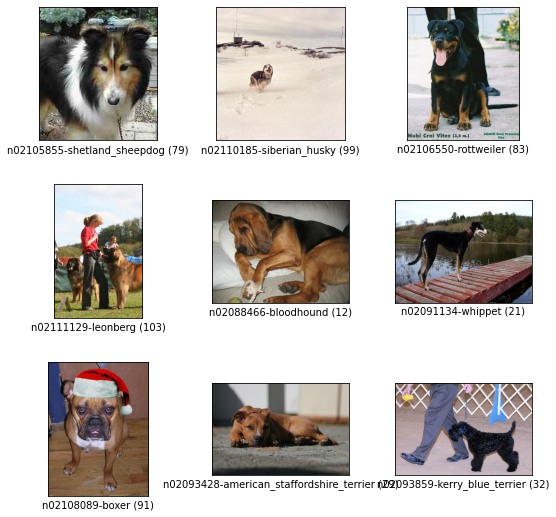

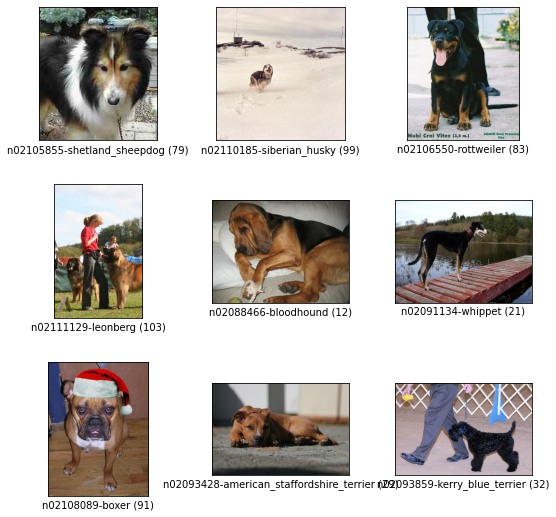

In [4]:
# train ds 확인
tfds.show_examples(ds_train, ds_info)

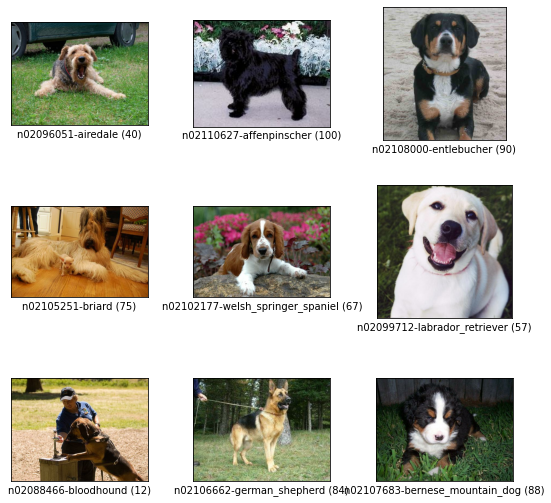

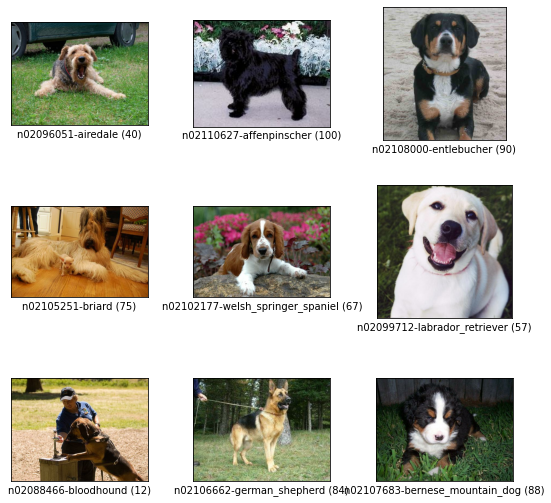

In [5]:
# test ds 확인
tfds.show_examples(ds_test, ds_info)

# 6-3 CAM, Grad-CAM용 모델 준비하기 2. 물체의 위치정보

In [6]:
# ds_info 로 features 구성 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- `image`와 `label`은 입력이미지와 이미지에 해당하는 정답클래스의 인덱스
- bbox는 물체의 위치를 사각형으로 표기하는 방법.

### Bounding Box를 표기하는 방법

보통 'xywh', or 'minmax'로 표기

- **'xywh'** 는 바운딩박스 중심점을 x,y로 표기하고 사각형의 너비 w와 높이 h로 표기
    - x,y가 중심점이 아니고 좌상단 점을 가리킬 수도 있음
    
    
- **'minmax'** 는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법
    - ex (xmin, xmax, ymin, ymax)
    - 이미지의 너비와 높이를 기준으로 상대적인 값을 표기
    
- 데이터 및 라이브러리 마다 간단한 바운딩박스 정보를 확인하고 넘어가야함

# 6-4 CAM, Grad-CAM용 모델 준비하기 3. CAM을 위한 모델 만들기

- ImageNet 데이터에 훈련된 `ResNet50` 기반으로 pooling layer 뒤에 softmax를 붙여서 Grad-CAM 모델을 만든다.

- 참고로 softmax layer는 softmax를 활성화함수로 하는 fully-connected layer

### 구현

In [7]:
num_classes = ds_info.features['label'].num_classes

base_model = keras.applications.resnet50.ResNet50(include_top=False, # fully connected-layer 제거
                                                  weights='imagenet',
                                                  input_shape=(224,224,3),
                                                  pooling='avg'
                                                 )

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


- fully connected layer 대신 GAP을 사용해주어야 하는데 여기서는 pooling='avg'로 쉽게 붙일 수 있다.

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# 6-5 CAM, Grad-CAM용 모델 준비하기 4. CAM 모델 학습하기

- 학습데이터와 검증데이터에 normaization 과 resizing을 포함한 전처리
- input에서는 bbox 정보가 포함되어 있지만, CAM에서는 필요가없으므로 제외

In [9]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32)/255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 배치모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# model compile

tf.random.set_seed(2022)
cam_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(lr=1e-2),
                  metrics=['accuracy']
                 )

In [12]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
                                  validation_steps=int(ds_info.splits['test'].num_examples/16),
                                  epochs=15, # 보통 15~20
                                  validation_data=ds_test_norm,
                                  verbose=1,
                                  use_multiprocessing=True
                                 )

Epoch 1/15
750/750 [==============================] - 373s 446ms/step - loss: 3.1814 - accuracy: 0.2850 - val_loss: 3.1656 - val_accuracy: 0.2509
Epoch 2/15
750/750 [==============================] - 333s 444ms/step - loss: 0.8941 - accuracy: 0.7467 - val_loss: 1.0771 - val_accuracy: 0.6888
Epoch 3/15
750/750 [==============================] - 347s 463ms/step - loss: 0.2863 - accuracy: 0.9369 - val_loss: 1.0167 - val_accuracy: 0.7047
Epoch 4/15
750/750 [==============================] - 333s 444ms/step - loss: 0.0757 - accuracy: 0.9914 - val_loss: 0.9704 - val_accuracy: 0.7222
Epoch 5/15
750/750 [==============================] - 333s 445ms/step - loss: 0.0379 - accuracy: 0.9981 - val_loss: 0.9183 - val_accuracy: 0.7358
Epoch 6/15
750/750 [==============================] - 333s 444ms/step - loss: 0.0200 - accuracy: 0.9992 - val_loss: 0.9403 - val_accuracy: 0.7390
Epoch 7/15
750/750 [==============================] - 333s 444ms/step - loss: 0.0232 - accuracy: 0.9991 - val_loss: 0.9860 -

In [15]:
# 학습시킨 가중치 저장
import os

cam_model_path = os.getenv("HOME")+'/aiffel/class_activation_map/cam_model_epoch15.h5'
cam_model.save(cam_model_path)

# 6-6 CAM

- 이제 학습한 모델을 활용하여 CAM 생성

In [6]:
# 커널 재시작 후 코드들을 모아 한꺼번에 실행

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train','test'],
                                         shuffle_files=True,
                                         with_info=True
                                        )

def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32)/255.
    return input['image'], input['label']


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls=2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


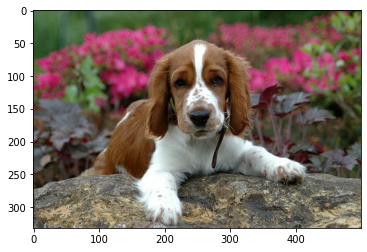

In [8]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 데이터가 준비 되었으므로 CAM을 생성하기 위한 학습한 모델 불러오기

In [9]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_epoch15.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- CAM을 생성하기 위해서는 1. 특성맵, 2. 클래스별 확률을 얻기위한 소프트맥스 레이어 가중치, 3. 원하는 클래스 출력값이 필요

- 또한 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 해야 모델이 어떤부분을 보는지 알게 시각화를 해야한다.
- model, item을 받았을 때 입력이미지와 동일한 크기의 CAM을 반환하는 함수를 만든다.


- `generate_cam()`을 구현하기 위해서는 `conv_outputs`과 같이 특정 레이어 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현, 마지막에는 입력이미지 크기에 맞춰 CAM을 resize

In [10]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

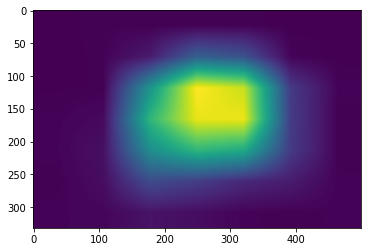

In [11]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [12]:
# CAM image + 원본이미지 func

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0-alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

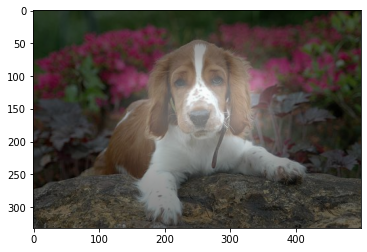

In [13]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 6-7 Grad-CAM

- Grad-CAM을 이용하여 CAM을 얻는다

71


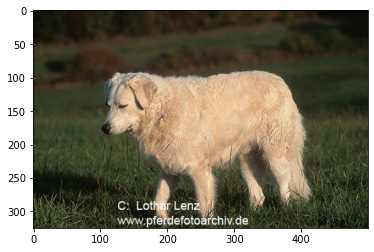

In [14]:
# 새로운이미지
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- `grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게된다.

- Grad-CAM 은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아 쓸 수 있도록 이름을 받고 이를 활용

In [15]:
# 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val 을 얻고 이를 weights로 활용

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으므로 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

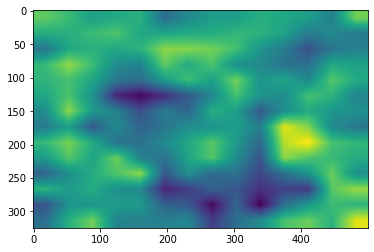

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block2_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 6-8 Detection with CAM

### bounding box

- CAM에서 물체의 위치를 찾는 detection

80


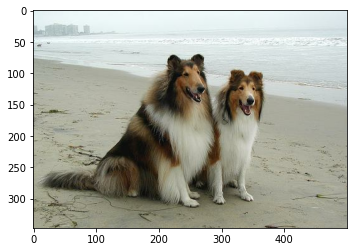

In [17]:
# 새로운 이미지
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

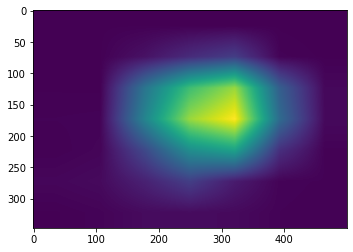

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 score_thresh 를 받아 역치값 이하의 바운딩 박스는 없앤다.

- 

In [19]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [20]:
rect = get_bbox(cam_image)
rect

array([[ 97,  67],
       [440,  18],
       [477, 282],
       [134, 331]])

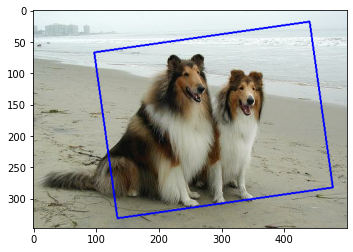

In [21]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection over Union

In [22]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [23]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05187319884726225, 0.194, 0.9538904899135446, 0.954]

In [24]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [25]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [26]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3365492865947617

# 6-9 프로젝트 : CAM 을 만들고 평가

### CAM 구현

11


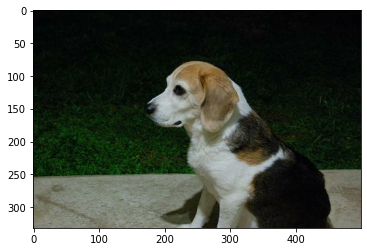

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [28]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [29]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

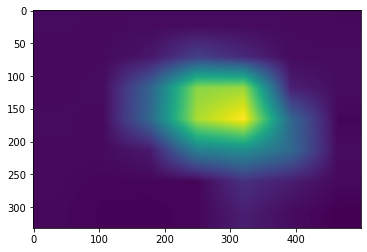

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [31]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

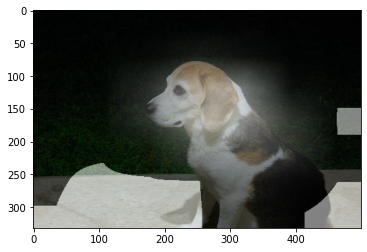

In [32]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Grad-CAM 구현

23


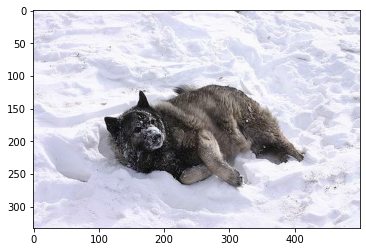

In [33]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [34]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


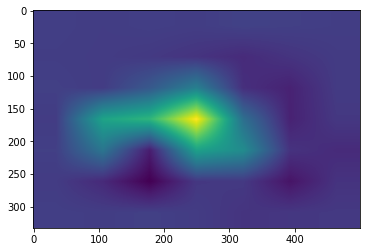

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

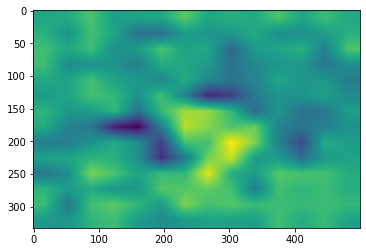

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

### 바운딩박스 구하기


In [67]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [68]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [69]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09337349397590361, 0.218, 0.9246987951807228, 0.89]

### IoU 구하기

In [70]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [72]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7286566026322541

### 원본

100


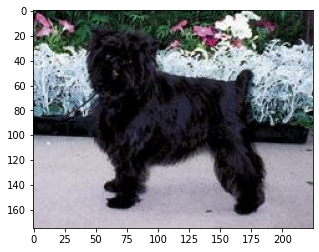

In [73]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

### CAM 결과

In [74]:
cam_image = generate_cam(cam_model, item)


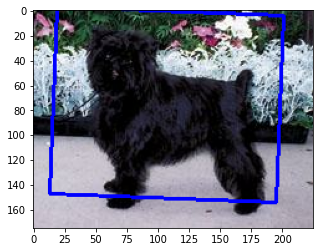

In [75]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### Grad_CAM 결과

In [77]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)

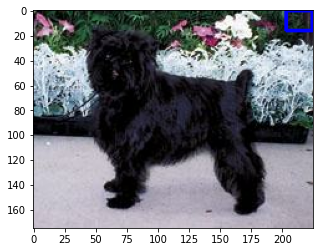

In [78]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

### 

In [86]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

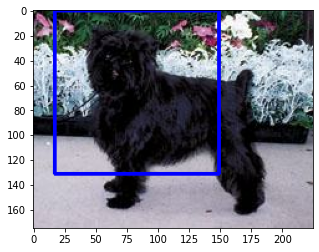

In [87]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

### 고찰

- Grad_cam에서는 Conv5_block3_out 층에서 성능이 더 잘 나왔다.

- CAM과 Grad_CAM의 성능차이는 왔다갔다 하지만, Grad_CAM에서는 레이어에 따라 성능차이가 있다.